In [1]:
from sam import chdir_to_repopath
chdir_to_repopath()

from sam.stress_addition_model import (
    sam_prediction,
    get_sam_lcs,
    OLD_STANDARD
)
import os
from sam.dose_reponse_fit import dose_response_fit, ModelPredictions, FitSettings
from sam.plotting import plot_fit_prediction

from sam.plotting import plot_sam_prediction
from sam.data_formats import load_datapoints, read_data, load_files
from sam.system_stress import calc_system_stress
from sam.helpers import detect_hormesis_index
import matplotlib.pyplot as plt
import pandas as pd
from sam.plotting import *
import argparse
from tqdm import tqdm

PLOT_PATH = "control_imgs/sam_prediction"
SETTINGS = OLD_STANDARD

In [2]:
def sys_plot(model, example, setting, hormesis_index):
    cleaned_surv_func, system_stress_func = calc_system_stress(
        example.main_series, dose_response_fit = model, hormesis_index=hormesis_index, cfg=setting
    )

    cleaned_surv = cleaned_surv_func(model.concentration_curve) 
    cleaned_stress = setting.survival_to_stress(cleaned_surv)
    cleaned_surv *= example.meta.max_survival

    system_stress = system_stress_func(model.concentration_curve)
    system_surv = setting.stress_to_survival(system_stress) * example.meta.max_survival


    # Create the plot
    title = f"{example.meta.chemical} - {example.meta.organism}"

    fig, axs = plt.subplots(2, 2, figsize=(10, 6))


    def plot_surv(y, label, orig_series=None):
        plot_survival(
            model.concentration_curve,
            y,
            label = label,
            ax=axs[0, 0],
            orig_series=orig_series,
            xscale="linear",
            show_legend=False,
            xlab=None,
            ylab="Survival",
            title="Survival",
            color = None,
            hormesis_index=hormesis_index,
        )

        plot_survival(
            model.concentration_curve,
            y,
            label = label,
            ax=axs[1, 0],
            orig_series=orig_series,
            xscale="log",
            show_legend=False,
            xlab=None,
            ylab="Survival",
            color = None,
            hormesis_index=hormesis_index,
            title="Survival",
        )


    plot_surv(model.survival_curve, label="measurment", orig_series=model.inputs)
    plot_surv(cleaned_surv, label="without hormesis", orig_series=None)
    plot_surv(system_surv, label="system", orig_series=None)



    def plot_str(y, label):
        plot_stress(
            model.concentration_curve,
            y,
            label=label,
            ax=axs[0, 1],
            xscale="linear",
            show_legend=False,
            xlab=None,
            ylab="Stress",
            title="Stress",
            color =None,
        )

        plot_stress(
            model.concentration_curve,
            y,
            label=label,
            ax=axs[1, 1],
            xscale="log",
            show_legend=False,
            xlab=None,
            ylab="Stress",
            title="Stress",
            color =None,
        )

    plot_str(model.stress_curve, label="measurment")
    plot_str(cleaned_stress, label="without hormesis")
    plot_str(system_stress, label="system")

    axs[-1,-1].legend()

    if title:
        fig.suptitle(title)

    plt.tight_layout()
    return fig

In [3]:
path = "data/huang_Flupyradifurone_2023.xlsx"

 11%|█         | 2/18 [00:03<00:28,  1.80s/it]

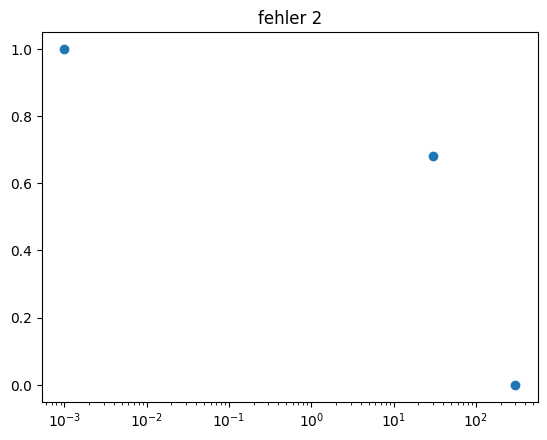

Weibull 2-param fit failed, defaulting to linear regression


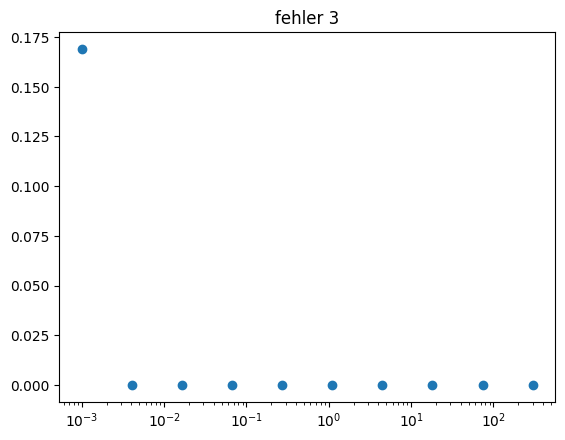

Weibull 3-param fit failed, defaulting to linear regression


 22%|██▏       | 4/18 [00:09<00:33,  2.38s/it]

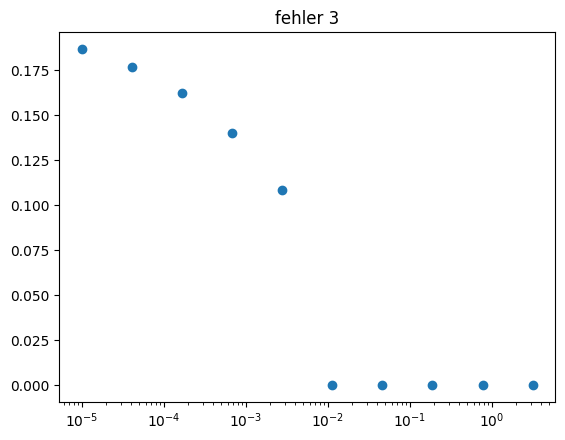

Weibull 3-param fit failed, defaulting to linear regression


 44%|████▍     | 8/18 [00:17<00:20,  2.01s/it]

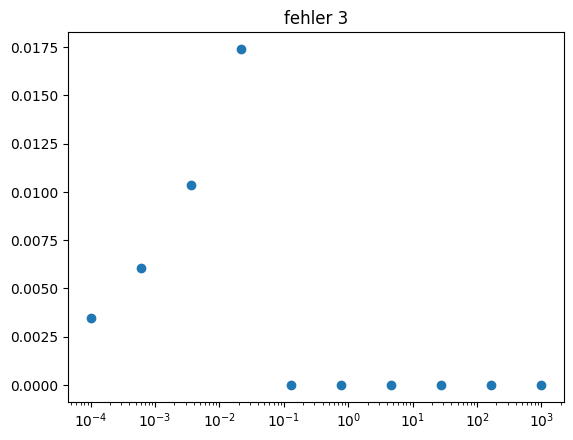

Weibull 3-param fit failed, defaulting to linear regression


 67%|██████▋   | 12/18 [00:25<00:11,  1.87s/it]

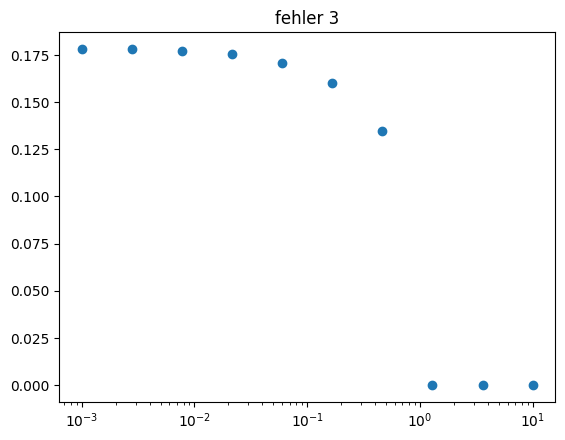

Weibull 3-param fit failed, defaulting to linear regression


100%|██████████| 18/18 [00:36<00:00,  2.03s/it]


In [4]:
save_dir = "control_imgs/hormesis_and_sys"

for path, data in tqdm(load_files()):
    setting = FitSettings(survival_max=data.meta.max_survival)

    model: ModelPredictions = dose_response_fit(
        data.main_series, cfg = setting
    )

    hormesis_index = detect_hormesis_index(data.main_series.survival_rate)

        
    if hormesis_index is not None:
        fig = sys_plot(model, data, setting, hormesis_index)    

    else:
        title = f"{data.meta.chemical} - {data.meta.organism}"
        fig = plot_fit_prediction(model=model, title=title)

    # Save the plot
    save_path = os.path.join(save_dir, f"{os.path.split(path.replace('xlsx', 'png'))[1]}")
    fig.savefig(save_path)
    plt.close(fig)


In [3]:
names = [
    ("liess_copper_2001", "Food_1% + UV"),
    ("naeem_Esfenvalerate_2019", "Food_1% + Prochloraz_100"),
    
]

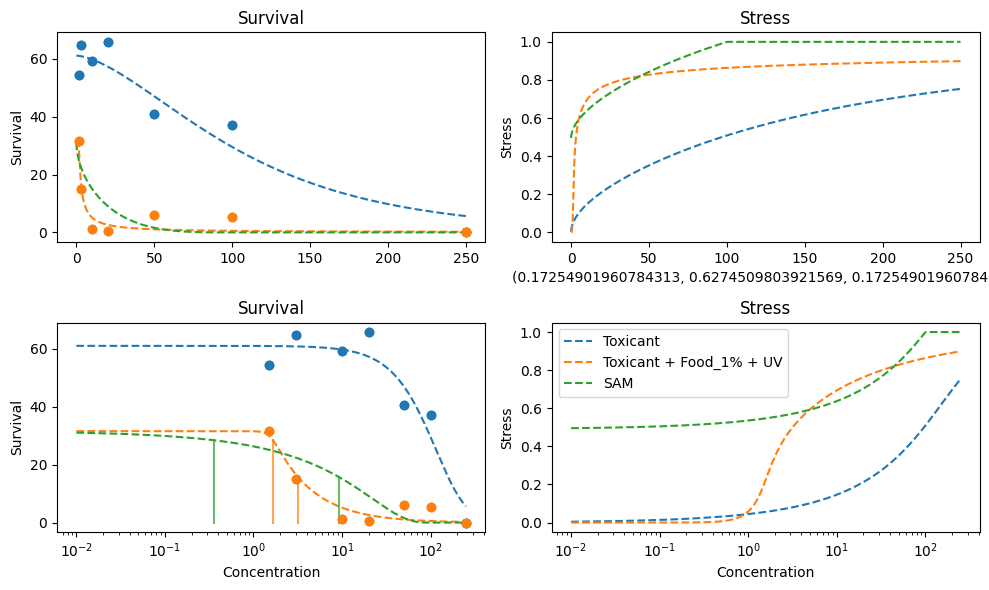

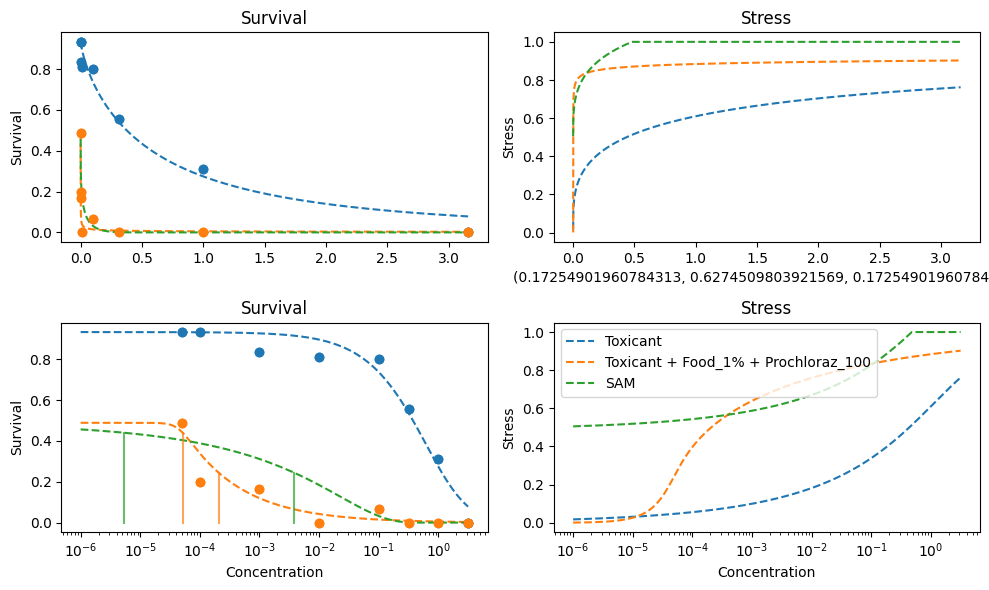

In [4]:
from sam.stress_addition_model import OLD_STANDARD, sam_prediction
from sam.stress_addition_model import (
    sam_prediction,
    get_sam_lcs,
    OLD_STANDARD
)
from sam.plotting import plot_sam_prediction
from sam.data_formats import load_datapoints
import os
import matplotlib.pyplot as plt
import pandas as pd
import argparse
from tqdm import tqdm
from copy import deepcopy



def pred_exp(path, exp, new = False, hormesis_index = None):
    
    settings = deepcopy(OLD_STANDARD)
    settings.cancel_system_stress = new
    
    
    data = read_data(f"data/{path}.xlsx")
    data.meta.hormesis_index = hormesis_index
    val = data.additional_stress[exp]
    
    main_fit, stress_fit, sam_sur, sam_stress, additional_stress = sam_prediction(
        data.main_series,
        val,
        data.meta,
        settings=settings,
    )

    lcs = get_sam_lcs(stress_fit=stress_fit, sam_sur=sam_sur, meta=data.meta)

    title = None
    fig = plot_sam_prediction(
        main_fit,
        stress_fit,
        sam_sur,
        sam_stress,
        survival_max=data.meta.max_survival,
        lcs=lcs,
        title=title,
    )
    plt.show()
    
    
    
for path, exp in names:
    data = read_data(f"data/{path}.xlsx")
    val = data.additional_stress[exp]
    
    main_fit, stress_fit, sam_sur, sam_stress, additional_stress = sam_prediction(
        data.main_series,
        val,
        data.meta,
        settings=settings,
    )

    lcs = get_sam_lcs(stress_fit=stress_fit, sam_sur=sam_sur, meta=data.meta)

    title = None
    fig = plot_sam_prediction(
        main_fit,
        stress_fit,
        sam_sur,
        sam_stress,
        survival_max=data.meta.max_survival,
        lcs=lcs,
        title=title,
    )
    plt.show()
        # name = os.path.split(path)[1].replace(".xlsx", f"_{name}.png")
        # save_path = os.path.join(PLOT_PATH, name)

        # fig.savefig(save_path)

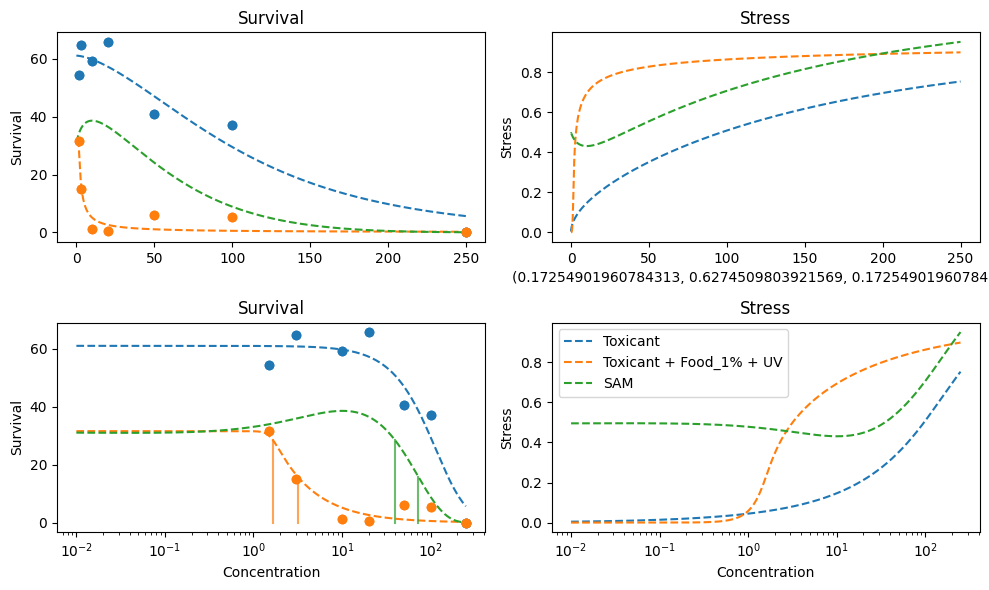

TypeError: '<' not supported between instances of 'NoneType' and 'int'

In [14]:
from copy import deepcopy
new_sets = deepcopy(OLD_STANDARD)
new_sets.cancel_system_stress = True

for path, exp in names:
    data = read_data(f"data/{path}.xlsx")
    val = data.additional_stress[exp]
    
    
    main_fit, stress_fit, sam_sur, sam_stress, additional_stress = sam_prediction(
        data.main_series,
        val,
        data.meta,
        settings=new_sets,
    )

    lcs = get_sam_lcs(stress_fit=stress_fit, sam_sur=sam_sur, meta=data.meta)

    title = None
    fig = plot_sam_prediction(
        main_fit,
        stress_fit,
        sam_sur,
        sam_stress,
        survival_max=data.meta.max_survival,
        lcs=lcs,
        title=title,
    )
    plt.show()

In [8]:
experiments = [
    "control_imgs/sam_prediction/liess_copper_2001_Food_1% + UV.png",
    "control_imgs/sam_prediction/naeem_Esfenvalerate_2019_Food_1% + Prochloraz_100.png",
    ]


for path in os.listdir("data"):
    
    data = read_data("data/" + path)
    for name in data.additional_stress:
        
        if len(name.split(" + ")) > 1:
            experiments.append((path, name))

experiments

[('naeem_Mix13_2024.xlsx', 'Temp_25 + Food_1%'),
 ('naeem_Esfenvalerate_2024.xlsx', 'Food_1% + Temp_25'),
 ('liess_copper_2001.xlsx', 'Food_1% + UV'),
 ('bps_esf_food_2024.xlsx', 'Esfenvalerate + Food_1%'),
 ('naeem_Esfenvalerate_2019.xlsx', 'Food_1% + Prochloraz_1'),
 ('naeem_Esfenvalerate_2019.xlsx', 'Food_1% + Prochloraz_32'),
 ('naeem_Esfenvalerate_2019.xlsx', 'Food_1% + Prochloraz_100'),
 ('naemm_Clothianidin_2024_reference.xlsx', 'Temp_19 + Prochloraz_1'),
 ('naemm_Clothianidin_2024_reference.xlsx', 'Temp_19 + Prochloraz_10'),
 ('naemm_Clothianidin_2024_reference.xlsx', 'Temp_22 + Prochloraz_1'),
 ('naemm_Clothianidin_2024_reference.xlsx', 'Temp_22 + Prochloraz_10'),
 ('naemm_Clothianidin_2024_agricultural.xlsx', 'Temp_19 + Prochloraz_1'),
 ('naemm_Clothianidin_2024_agricultural.xlsx', 'Temp_19 + Prochloraz_10'),
 ('naemm_Clothianidin_2024_agricultural.xlsx', 'Temp_22 + Prochloraz_1'),
 ('naemm_Clothianidin_2024_agricultural.xlsx', 'Temp_22 + Prochloraz_10')]